In [1]:
import matplotlib
import mesa
import pandas as pd
import enum
import math
import numpy as np
import networkx as nx
import matplotlib as mpl
from celluloid import Camera
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.batchrunner import BatchRunner
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

In [2]:
def euclidean_dist(x, y):
    return math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))
    
class Status(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = -1
    RECOVERED = 1

class CovidAgent(Agent):
    """ An agent with fixed initial position and status."""
    def __init__(self, unique_id, model, xInit, yInit, destinations = []):
        super().__init__(unique_id, model)
        self.init_pos = (xInit, yInit)
        self.target_pos = None
        self.status = Status.SUSCEPTIBLE
        self.infection_time = 0
        self.destinations = destinations
        self.infected_at = 0
        
    def step(self):
        self.check()
        self.interact()
        self.move()
        
    def check(self):
        if self.status == Status.INFECTED:
            death_prob = self.model.death_prob
            np.random.seed = self.random.seed
            is_alive = np.random.choice([0,1], p=[death_prob, 1-death_prob])
            if is_alive == 0:
                self.model.schedule.remove(self)            
                self.model.deaths += 1
            elif self.model.schedule.time - self.infected_at >= self.model.treatment_period:
                self.status = Status.RECOVERED
        
    def move(self):
        self.set_target_pos()
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = self.select_new_pos( possible_steps) 
        self.model.grid.move_agent(self, new_position)
        
    def interact(self):
        contacts = self.model.grid.get_cell_list_contents([self.pos])       
        for c in contacts:
            if self.status is Status.INFECTED and c.status is not Status.INFECTED:
                infect = self.random.random() <= self.model.infection_prob
                if infect == True:
                    c.status = Status.INFECTED
                    c.infected_at = self.model.schedule.time
                    self.model.addInfection(self.unique_id, c.unique_id) 
        
    def set_target_pos( self ):
        #at home = select a random destination
        if self.pos == self.init_pos:
            self.target_pos = self.random.choice( self.destinations )
        #at destination
        elif self.pos == self.target_pos:
            self.target_pos = self.init_pos
    
    def select_new_pos( self, possible_steps ):
        if self.status == Status.INFECTED:
            has_symptoms = self.model.schedule.time - self.infection_time >= self.model.incubation_period
            # rule 1: infected with symptoms at home = stay at home
            if self.pos == self.init_pos and has_symptoms == True:
                return self.init_pos
            # rule 2: infected with symptoms not at home -> return to home
            elif self.pos != self.init_pos and has_symptoms == True:
                self.target_pos = self.init_pos
        
        return self.calculate_new_pos( possible_steps )
    
    def calculate_new_pos( self, possible_steps ):
        next_step = possible_steps[0]
        next_dist = euclidean_dist(self.target_pos, next_step) 
        for step in possible_steps:
            dist = euclidean_dist(self.target_pos, step)
            if dist < next_dist:
                next_step = step
        return next_step

In [3]:
class CovidModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height, infection_prob, death_prob, incubation_period, treatment_period, sim_destinations, seed=None):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.infection_prob = infection_prob
        self.death_prob = death_prob
        self.incubation_period= incubation_period
        self.treatment_period = treatment_period
        self.deaths = 0
        self.DG = nx.DiGraph()
        self.running = True
        #adds a fixed number of possible destinations
        self.destinations = []
        for idx in range(sim_destinations):
            self.destinations.append( (self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)) )
            
        # Create agents
        for i in range(self.num_agents):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            a = CovidAgent(i, self, x, y, self.destinations)
            if i == 7:
                a.status = Status.INFECTED
                self.DG.add_nodes_from([(i,{"color": "green"})])
            else:
                self.DG.add_nodes_from([(i,{"color": "orange"})])
            self.schedule.add(a)
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (x, y))
            
        self.datacollector = DataCollector(
            model_reporters={"S": compute_S, "I": compute_I, "R": compute_R, "D": compute_D, "AvgDegree": compute_degree}
            ,agent_reporters={"Status": "status", "Position": "pos"}
            )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        
    def addInfection(self, agentIdSrc, agentIdDes):
        self.DG.add_edge(agentIdSrc, agentIdDes)

In [4]:
def compute_S(model):
    agents = len([agent.status for agent in model.schedule.agents if agent.status == Status.SUSCEPTIBLE])
    return agents

def compute_I(model):
    agents = len([agent.status for agent in model.schedule.agents if agent.status == Status.INFECTED])
    return agents

def compute_R(model):
    agents = len([agent.status for agent in model.schedule.agents if agent.status == Status.RECOVERED])
    return agents

def compute_D(model):
    agents = model.num_agents - len(model.schedule.agents)
    return  agents

def compute_degree(model):
    degree = np.median([t[1] for t in model.DG.degree()])
    return degree

## Runs the model

In [5]:
maxX = maxY = 20
sim_steps = 100
sim_agents = 175
sim_infection_prob = 0.7
sim_death_prob = 0.05
sim_incubation_period = 3
sim_treatment_period = 14
sim_destinations = 10
sim_rand_seed = 4
model = CovidModel(sim_agents, maxX, maxY, sim_infection_prob, sim_death_prob, sim_incubation_period, sim_treatment_period, sim_destinations, seed = sim_rand_seed)
for i in range(sim_steps):
    model.step()
sir_df = model.datacollector.get_model_vars_dataframe()

### Agents individual data

In [6]:
agents_data = model.datacollector.get_agent_vars_dataframe()
agents_data[['xPos', 'yPos']] = pd.DataFrame(agents_data["Position"].to_list(), index=agents_data.index, columns=['xPos', 'yPos'])
df_agents = (agents_data.reset_index(level=0)).reset_index(level=0)

### Plot agent movement

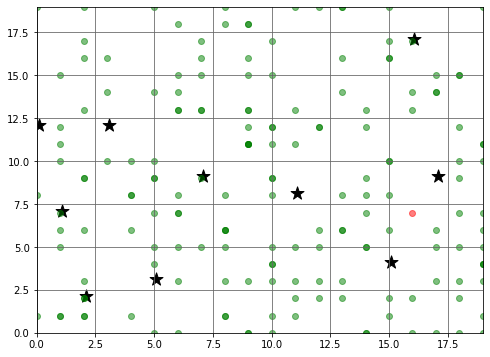

In [7]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_xlim(( 0, maxX-1))
ax.set_ylim(( 0, maxY-1))
for st in model.destinations:
    ax.scatter(st[0],st[1],s=300,color='black', marker=r'$\star$', label="Destination")
curr_step = df_agents.loc[(df_agents['Step']==0) & (df_agents['Status']==Status.SUSCEPTIBLE)]
ax.scatter(curr_step['xPos'],curr_step['yPos'],alpha=0.5,color='green')
curr_step = df_agents.loc[(df_agents['Step']==0) & (df_agents['Status']==Status.INFECTED)]
ax.scatter(curr_step['xPos'],curr_step['yPos'],alpha=0.5,color='red')
plt.grid(b=True, which='major', color='#666666', linestyle='-')

## Draw the network

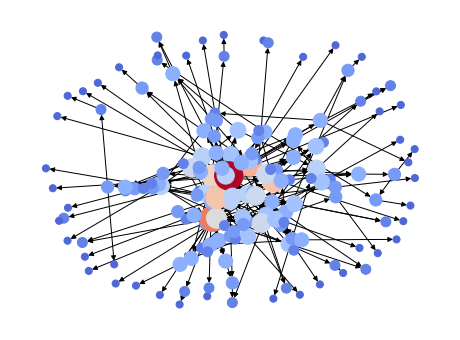

In [8]:
fig, ax = plt.subplots(1, figsize=(8, 6))
degrees = [50* t[1] for t in model.DG.degree()]
low, *_, high = sorted(degrees)
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
options = {
    'node_size': degrees
    , 'node_color': [mapper.to_rgba(i) for i in degrees]
}
nx.draw_spring(model.DG, **options)

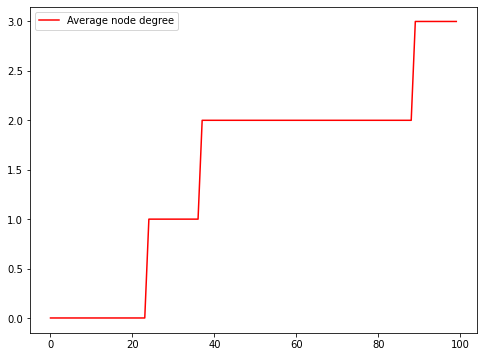

In [9]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_xlabel = 'Step'
ax.set_title = 'SIR behaviour'
ax.plot(range(sim_steps), sir_df['AvgDegree'], label='Average node degree', color='red')
ax.legend()

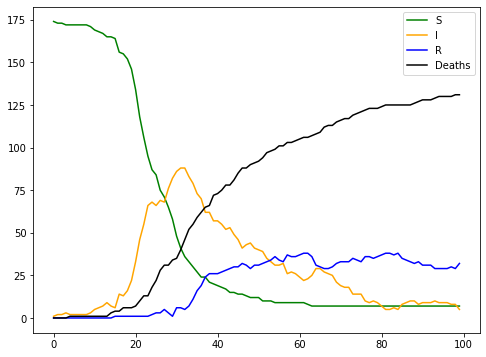

In [10]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_xlabel = 'Step'
ax.set_title = 'SIR behaviour'
ax.plot(range(sim_steps), sir_df['S'], label='S', color='green')
ax.plot(range(sim_steps), sir_df['I'], label='I', color='orange')
ax.plot(range(sim_steps), sir_df['R'], label='R', color='blue')
ax.plot(range(sim_steps), sir_df['D'], label='Deaths', color='black')
ax.legend()

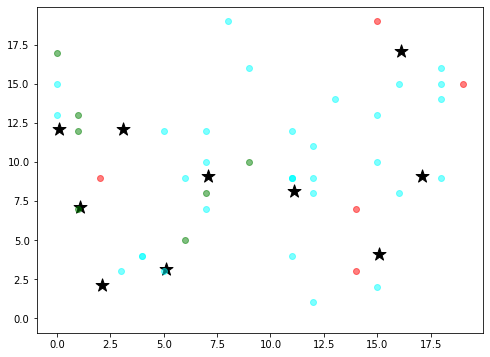

In [11]:
fig, ax = plt.subplots(1, figsize=(8, 6))
camera = Camera(fig)    
for s in range(sim_steps):
    for st in model.destinations:
        ax.scatter(st[0],st[1],s=300,color='black', marker=r'$\star$', label="Destination")
    #plot susceptibles
    curr_step = df_agents.loc[(df_agents['Step']==s) & (df_agents['Status']==Status.SUSCEPTIBLE)]
    ax.scatter(curr_step['xPos'],curr_step['yPos'],alpha=0.5,color='green')
    curr_step = df_agents.loc[(df_agents['Step']==s) & (df_agents['Status']==Status.INFECTED)]
    ax.scatter(curr_step['xPos'],curr_step['yPos'],alpha=0.5,color='red')
    curr_step = df_agents.loc[(df_agents['Step']==s) & (df_agents['Status']==Status.RECOVERED)]
    ax.scatter(curr_step['xPos'],curr_step['yPos'],alpha=0.5,color='cyan')
    camera.snap()
anim = camera.animate(blit=True)
HTML(anim.to_html5_video())

## Batch running

In [12]:
fixed_params = {
     "N" : 175
    ,"width" : 20
    ,"height" : 20
    ,"incubation_period" : 3
    ,"treatment_period" : 14
}
variable_params = {
    "sim_destinations": range(3, 10, 1)
    , "infection_prob": [x / 10.0 for x in range(3, 8, 1)]
    , "death_prob": [x / 10.0 for x in range(2, 8, 1)]
}

batch_run = BatchRunner(CovidModel,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=sim_steps,
                        model_reporters={"S": compute_S, "I": compute_I, "R": compute_R, "D": compute_D})
batch_run.run_all()

1050it [07:42,  2.27it/s]


In [13]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()

,sim_destinations,infection_prob,death_prob,Run,D,I,R,S,N,width,height,incubation_period,treatment_period
0,3,0.3,0.2,0,3,0,0,172,175,20,20,3,14
1,3,0.3,0.2,1,0,0,1,174,175,20,20,3,14
2,3,0.3,0.2,2,1,0,0,174,175,20,20,3,14
3,3,0.3,0.2,3,17,0,1,157,175,20,20,3,14
4,3,0.3,0.2,4,1,0,0,174,175,20,20,3,14


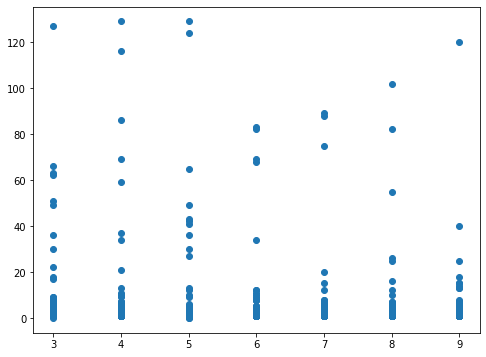

In [14]:
fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(run_data.sim_destinations, run_data.D)

(array([994.,  17.,   9.,   7.,   4.,   6.,   6.,   1.,   1.,   5.]),
 array([  0. ,  12.9,  25.8,  38.7,  51.6,  64.5,  77.4,  90.3, 103.2,
        116.1, 129. ]),
 <BarContainer object of 10 artists>)

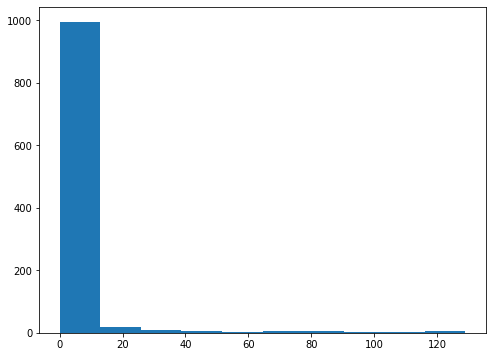

In [15]:
fig, ax = plt.subplots(1, figsize=(8, 6))
plt.hist(run_data.D)